In [50]:
import cobra
import numpy as np
import pickle
import os

# Function to calculate the stoichiometry matrix
def stoichiometry_calc(model):
    """
    Calculate the stoichiometry matrix of a given metabolic model.
    """
    return cobra.util.array.create_stoichiometric_matrix(model, array_type='DataFrame')

# Function to calculate reversibility
def reversibility_calc(model):
    """
    Calculate the reversibility of reactions in a metabolic model.
    """
    try:
        return [1 if reaction.reversibility else 0 for reaction in model.reactions]
    except AttributeError:
        raise ValueError("Invalid model format. The model does not contain reactions attribute.")

# Function to calculate MFG
def MFG_calc(S, r, v):
    """
    Calculate the mass flow graph (MFG) based on stoichiometry matrix (S),
    reversibility vector (r), and flux sampling vector (v).
    """
    S = np.nan_to_num(S)  # Replace NaN values with 0

    I = np.eye(S.shape[1])  # Identity matrix
    D = np.diag(r)  # Diagonal matrix with the reversibility vector r

    A = np.block([[I, np.zeros((S.shape[1], S.shape[1]))], 
                  [np.zeros((S.shape[1], S.shape[1])), D]])

    B = np.block([S, -S])
    S_2m = B.dot(A)

    S_plus_2m = (np.abs(S_2m) + S_2m) / 2
    S_minus_2m = (np.abs(S_2m) - S_2m) / 2

    W_plus = np.linalg.pinv(np.diag(S_plus_2m.dot(np.ones(2 * S.shape[1]))))
    W_minus = np.linalg.pinv(np.diag(S_minus_2m.dot(np.ones(2 * S.shape[1]))))

    abs_v = np.abs(v)
    matrix1 = (abs_v + v) / 2
    matrix2 = (abs_v - v) / 2
    v_2m = np.vstack((matrix1, matrix2)).flatten()

    V = np.diag(v_2m)
    j = S_plus_2m.dot(v_2m)
    J = np.diag(j)
    J_pinv = np.linalg.pinv(J)

    return np.dot(np.dot(np.transpose(S_plus_2m.dot(V)), J_pinv), S_minus_2m.dot(V))

# Define paths
model_path = '/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/clean/c_models'
mfg_path = '/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG'

# Ensure the output directory exists
os.makedirs(mfg_path, exist_ok=True)

# Process each model
for model_file in os.listdir(model_path):
    if model_file.endswith(".xml"):
        full_model_path = os.path.join(model_path, model_file)
        model_name = os.path.splitext(model_file)[0]
        print(f"Processing model: {model_name}")

        # Load the model
        model = cobra.io.read_sbml_model(full_model_path)

        try:
            # Perform FBA
            o = cobra.flux_analysis.pfba(model)
            flux = o.fluxes
            gr = flux.get('BIOMASS_BS_10', None)
            print(f"Growth rate for {model_name}: {gr}")
        except Exception as e:
            print(f"FBA failed for {model_name}. Error: {e}")
            continue

        # Convert flux to numpy array
        v = flux.to_numpy()
        print(f"Flux vector length: {len(v)}")

        # Calculate stoichiometry matrix
        S = stoichiometry_calc(model)
        print(f"Stoichiometry matrix S (shape: {S.shape}):\n", S.head())

        # Calculate reversibility
        r = reversibility_calc(model)
        print(f"Reversibility vector r (length: {len(r)}):\n", r)

        # Ensure inputs are valid
        if S.empty or len(r) != S.shape[1]:
            print(f"Invalid inputs for MFG calculation for {model_name}. Skipping.")
            continue

        try:
            # Calculate MFG
            M = MFG_calc(S.values, r, v)
            print(f"MFG Matrix (shape: {M.shape}):\n", M)

            # Save MFG
            mfg_file_path = os.path.join(mfg_path, f"{model_name}_MFG.pkl")
            with open(mfg_file_path, 'wb') as f:
                pickle.dump(M, f)
            print(f"MFG saved for {model_name} at {mfg_file_path}")
        except Exception as e:
            print(f"Error calculating or saving MFG for {model_name}. Error: {e}")

Processing model: SwL1_transposed_filled_constrained
Growth rate for SwL1_transposed_filled_constrained: 0.17500554636251137
Flux vector length: 350
Stoichiometry matrix S (shape: (355, 350)):
           EX_ac_e  EX_fe3_e  EX_glc__D_e  EX_glu__L_e  EX_ca2_e  EX_cit_e  \
2dda7p_c      0.0       0.0          0.0          0.0       0.0       0.0   
2dmmq7_c      0.0       0.0          0.0          0.0       0.0       0.0   
2dr1p_c       0.0       0.0          0.0          0.0       0.0       0.0   
2ippm_c       0.0       0.0          0.0          0.0       0.0       0.0   
5aizc_c       0.0       0.0          0.0          0.0       0.0       0.0   

          EX_so4_e  EX_co2_e  EX_trp__L_e  EX_h2o_e  ...  TECA2S45  RNDR1  \
2dda7p_c       0.0       0.0          0.0       0.0  ...       0.0    0.0   
2dmmq7_c       0.0       0.0          0.0       0.0  ...       0.0    0.0   
2dr1p_c        0.0       0.0          0.0       0.0  ...       0.0    0.0   
2ippm_c        0.0       0.0       

In [51]:
import os
import pickle
import numpy as np

# Path to the MFG folder
mfg_path = '/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG'

# List all MFG files
mfg_files = [f for f in os.listdir(mfg_path) if f.endswith("_MFG.pkl")]

# Inspect each MFG
for mfg_file in mfg_files:
    file_path = os.path.join(mfg_path, mfg_file)
    print(f"Loading MFG file: {file_path}")

    # Load the MFG
    with open(file_path, 'rb') as f:
        MFG = pickle.load(f)
    
    # Check the structure
    print(f"MFG type: {type(MFG)}")
    if isinstance(MFG, np.ndarray):
        print(f"MFG shape: {MFG.shape}")
        print(f"MFG sample data:\n{MFG[:5, :5]}")  # Print a small sample of the data
    else:
        print("MFG is not a NumPy array. Content:")
        print(MFG)
    # print how many non zero elements are in the matrix

    print(f"Number of non-zero elements in MFG: {np.count_nonzero(MFG)}")

Loading MFG file: /Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG/SwL1_transposed_filled_constrained_MFG.pkl
MFG type: <class 'numpy.ndarray'>
MFG shape: (700, 700)
MFG sample data:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Number of non-zero elements in MFG: 8126
Loading MFG file: /Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG/kl2_transposed_filled_constrained_MFG.pkl
MFG type: <class 'numpy.ndarray'>
MFG shape: (692, 692)
MFG sample data:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Number of non-zero elements in MFG: 7947
Loading MFG file: /Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG/NtH1_transposed_filled_constrained_MFG.pkl
MFG type: <class 'numpy.ndarray'>
MFG shape: (680, 680)
MFG sample data:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Number of non-zero 

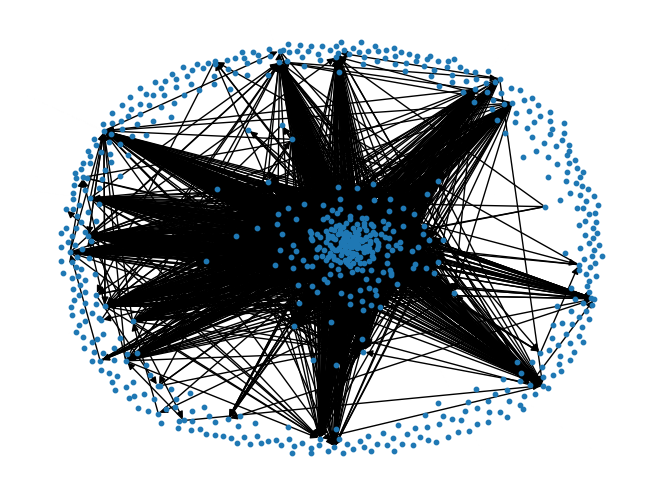

<Figure size 1000x1000 with 0 Axes>

In [52]:
# Load the MFG
with open('/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG/kl2_transposed_filled_constrained_MFG.pkl', 'rb') as f:
    MFG = pickle.load(f)

# create networkx graph

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from the MFG
G = nx.DiGraph(MFG)

# Visualize the graph

# Set the figure size


# Draw the graph
nx.draw(G, with_labels=False, node_size=10)
# prune the graph
# Remove nodes with no edges
G_pruned = G.copy()
for node in G.nodes():
    if G.in_degree(node) == 0 and G.out_degree(node) == 0:
        G_pruned.remove_node(node)

# set node size based on degree

# Calculate the degree of each node
node_degrees = dict(G_pruned.degree())


# Set the node size based on the degree
node_size = [v * 10 for v in node_degrees.values()]
plt.figure(figsize=(10, 10))



# Display the graph
plt.show()





In [53]:
mf_path ='/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Data/intermediate/MFG/kl2_transposed_filled_constrained_MFG.pkl'

# Load the MFG
with open(mf_path, 'rb') as f:
    MFG = pickle.load(f)

#inspect properties of the MFG

print(f"MFG type: {type(MFG)}")

if isinstance(MFG, np.ndarray):
    print(f"MFG shape: {MFG.shape}")
    print(f"MFG sample data:\n{MFG[:5, :5]}")  # Print a small sample of the data

else:
    print("MFG is not a NumPy array. Content:")
    print(MFG)

# list reactions with the highest out degree

# Create a directed graph from the MFG

G = nx.DiGraph(MFG)

# Get the out degree of each node

out_degrees = dict(G.out_degree())

# Sort the nodes by out degree

sorted_nodes = sorted(out_degrees, key=out_degrees.get, reverse=True)

# Print the top 10 nodes with the highest out degree

for node in sorted_nodes[:10]:

    print(f"Node: {node}, Out Degree: {out_degrees[node]}")

    

MFG type: <class 'numpy.ndarray'>
MFG shape: (692, 692)
MFG sample data:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Node: 73, Out Degree: 141
Node: 103, Out Degree: 90
Node: 104, Out Degree: 90
Node: 207, Out Degree: 73
Node: 77, Out Degree: 67
Node: 256, Out Degree: 67
Node: 83, Out Degree: 66
Node: 123, Out Degree: 66
Node: 179, Out Degree: 66
Node: 38, Out Degree: 65


In [40]:
import cobra
import networkx as nx
import numpy as np
import pickle

# Load the model
model = cobra.io.read_sbml_model('/Users/yahyafarooqi/Documents/Code/AntiGEM/FluxGraph/Models/Standard/subtilis_ iYO844.xml')

# Mapping reaction indices to reaction names
index_to_name = {i: rxn.id for i, rxn in enumerate(model.reactions)}

# Load the MFG
with open(mf_path, 'rb') as f:
    MFG = pickle.load(f)

# Create a directed graph from the MFG
G = nx.DiGraph(MFG)

# Get the out degree of each node
out_degrees = dict(G.out_degree())

# Sort the nodes by out degree and map them to reaction names
sorted_nodes = sorted(out_degrees, key=out_degrees.get, reverse=True)
top_nodes = [(index_to_name[node], out_degrees[node]) for node in sorted_nodes[:10]]

# Print the top nodes with the highest out degree
for name, degree in top_nodes:
    print(f"Reaction: {name}, Out Degree: {degree}")

Reaction: EX_arab__L_e, Out Degree: 141
Reaction: EX_chols_e, Out Degree: 90
Reaction: EX_chor_e, Out Degree: 90
Reaction: ACACT5r_1, Out Degree: 73
Reaction: EX_arsenb_e, Out Degree: 67
Reaction: EX_melib_e, Out Degree: 67
Reaction: EX_btd_RR_e, Out Degree: 66
Reaction: EX_succ_e, Out Degree: 66
Reaction: 2S6HCCi, Out Degree: 66
Reaction: EX_adn_e, Out Degree: 65
